# Classificador de Imagens

Classificador de imagens em escala de cinza, utilizando os algoritmos LBP e GLCM como extratores de características.


## Carregar as imagens

Carrega as imagens do dataset e as converte para escala de cinza

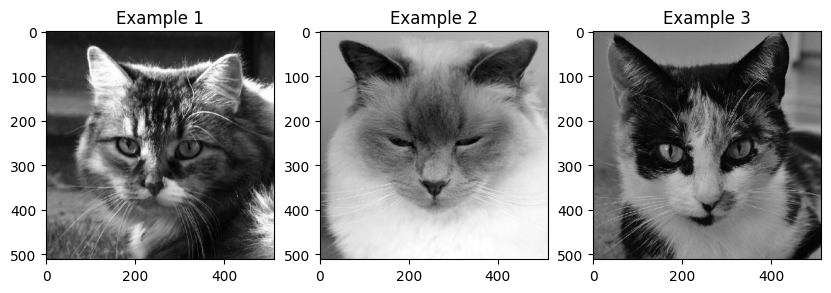

In [28]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

images_directory = './images/train'
image_categories = ['cats']

def load_images_from_category(category):
    gray_images = [rgb2gray(img) for img in ski.io.imread_collection(images_directory + f'/{category}/*.jpg')]
    gray_images_uint8 = [ski.util.img_as_ubyte(img) for img in gray_images]
    return gray_images_uint8

def load_train_images(categories):    
    return {category: load_images_from_category(category) for category in categories}

train_images_by_categories = load_train_images(image_categories)

train_images = train_images_by_categories['cats']

def show_tree_examples(images):
    imgs = images[0:3]
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, 3, i + 1)
        plt.imshow(img, cmap=plt.cm.gray)
        plt.title(f'Example {i+1}')
        plt.axis('on')

show_tree_examples(train_images)


Mostra o histograma da imagem para teste:

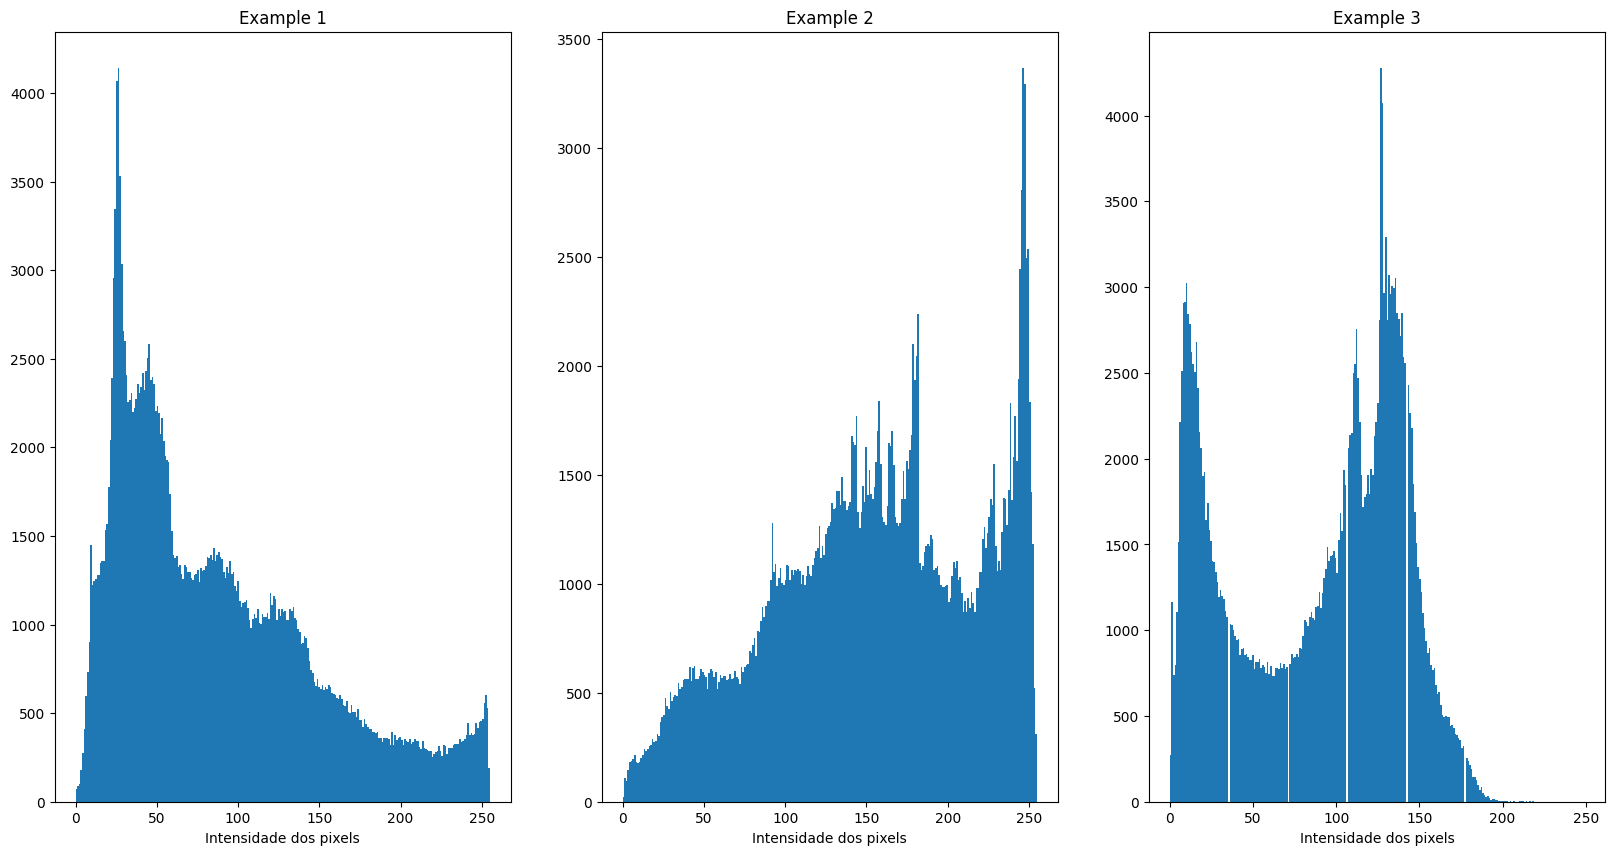

In [29]:
def show_tree_examples_histograms(images):
    imgs = images[0:3]
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(imgs):
        plt.subplot(1, 3, i + 1)
        plt.hist(img.ravel(), bins=256)
        plt.title(f'Example {i+1}')
        plt.axis('on')
        plt.xlabel('Intensidade dos pixels')

show_tree_examples_histograms(train_images)

## Extrair a estrutura das imagens de treino com LBP

Cada imagem tem sua própria estrutura. Todavia, imagens de objetos similares, via de regra, terão certa semelhança entre suas estruturas. Imagens de gatos terão certa semelhança entre suas estruturas, o mesmo vale para outros objetos.  

Nesse contexto, é possível utilizar o algoritmo **LBP (Local Binary Pattern)** para extrair a estrutura das imagens de treino e agrupá-las em categorias de estruturas.

In [30]:

# settings for LBP
radius = 3
n_pixels = 8 * radius

def compute_lbp_for_single_image(image, radius, n_points, method='uniform'):
    return local_binary_pattern(image, n_points, radius, method)

def compute_lbp_for_many_images(images, radius, n_points, method='uniform'):
    return [compute_lbp_for_single_image(img, radius, n_points, method) for img in images]

lbps = compute_lbp_for_many_images(train_images, radius, n_pixels)


Para visualizar a estrutura computada das imagens pode-se montar um histograma com as informações fornececidas pelo LBP.

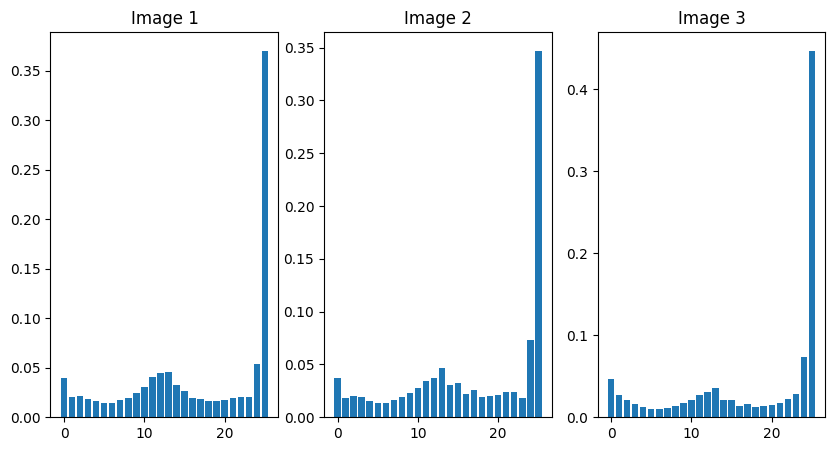

In [35]:
def build_histogram_from_lbp(lbp, n_pixels):
    (histogram, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_pixels + 3), range=(0, n_pixels + 2))

    # normalize the histogram
    histogram = histogram.astype("float")
    histogram /= (histogram.sum() + 1e-6)

    return histogram

def build_histogram_from_many_lbps(lbps, n_pixels, limit=3):
    target = lbps[0:limit]
    return [build_histogram_from_lbp(lbp, n_pixels) for lbp in target]

def show_sample_histograms(histograms):
    vals = range(len(histograms[0]))
    plt.figure(figsize=(10, 5))

    for i, sample in enumerate(histograms):
        plt.subplot(1, 3, i+1)
        plt.bar(vals, sample)
        plt.title(f"Image {i+1}")
        plt.axis('on')

sample_histograms = build_histogram_from_many_lbps(lbps, n_pixels, limit=3)
show_sample_histograms(sample_histograms)

## Extrair características utilizando o GLCM

Outro algoritmo muito bom para extrair características de imagens em escala de cinza é o GLCM (Gray-Level Co-Ocurrence Matrix).  
Esse algoritmo conta com algumas técnicas de extração de texturas, que podem ser utilizadas para extrair características da imagem. São elas: Contraste, Correlação, Energia e Homogeneidade. 

Abaixo serão extraídas as características da primeira imagem da fila de treino para teste.


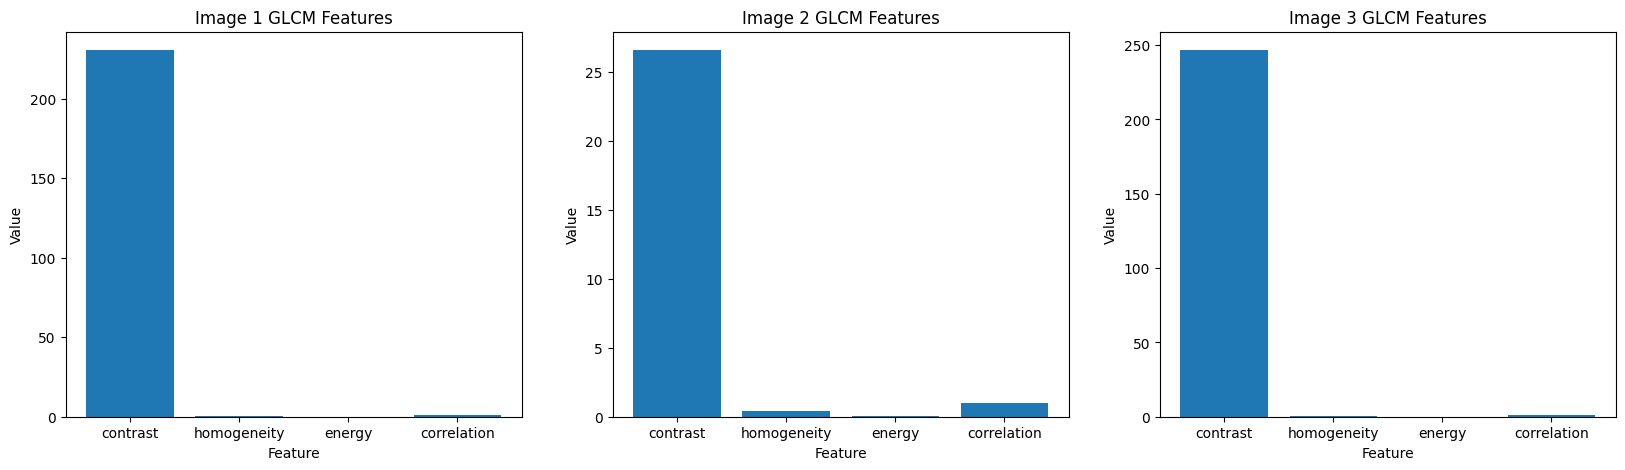

In [42]:
def calculate_glcm_from_single_image(image, distances, angles, levels, symmetric=True, normed=True):
    return graycomatrix(image, distances, angles, levels, symmetric=symmetric, normed=normed)

def calculate_glcm_from_many_images(images, distances, angles, levels, symmetric=True, normed=True):
    

    return [calculate_glcm_from_single_image(img, distances, angles, levels, symmetric, normed) for img in images]

distances = [1]
angles = [0]
levels = 256
glcm_features = ['contrast', 'homogeneity', 'energy', 'correlation']

glcm_list = calculate_glcm_from_many_images(train_images, distances, angles, levels)

def extract_glcm_features(glcm, props):
    return {prop: graycoprops(glcm, prop)[0, 0] for prop in props}

def extract_glcm_features_from_many_images(glcm_list, props):
    return [extract_glcm_features(glcm, props) for glcm in glcm_list]

features_result = extract_glcm_features_from_many_images(glcm_list, glcm_features)


def show_glcm_features_for_n_images(features, examples, n=3):
    target = examples[0:n]
    plt.figure(figsize=(20, 5))
    for i, feature in enumerate(target):        
        values = np.array(list(feature.values()))
        plt.subplot(1, 3, i+1)
        plt.bar(features, values)
        plt.title(f"Image {i+1} GLCM Features")
        plt.xlabel("Feature")
        plt.ylabel("Value")


example_features_values = np.array(list(features_result[0].values()))

# plt.bar(glcm_features, example_features_values)
# plt.title("GLCM Features")
# plt.xlabel("Feature")
# plt.ylabel("Value")
# plt.show()

show_glcm_features_for_n_images(glcm_features, features_result, n=3)

